In [1]:
import FinanceDataReader as fdr

In [2]:
import os
import numpy as np, pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [4]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [6]:
pip install pmdarima

     -------------------------------------- 572.0/572.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [8]:
import itertools

### 1.  주가데이터 불러오기

In [10]:
data = fdr.DataReader('360750', '2020-01-01') # TIGER 미국 S&P500

In [12]:
data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-08-07,9774,9789,9716,9761,126092,NaN
2020-08-10,9754,9794,9749,9785,212309,0.002459
2020-08-11,9789,9799,9774,9795,83181,0.001022
2020-08-12,9730,9754,9692,9757,68040,-0.003880
2020-08-13,9834,9834,9789,9805,163224,0.004920


In [13]:
data = data.rename(columns={'Close':'price'})

In [14]:
data = data.drop(['Open', 'High', 'Low','Volume', 'Change'], axis=1)

### 2. Box-Jenkins ARIMA Procedure
* 1. Data Preprocessing
* 2. Identity Model to be Tentatively Entertained
* 3. Estimate Parameter
* 4. Diagnosis Check
* 5. Use Models to Forecast

* 1. Data Preprocessing


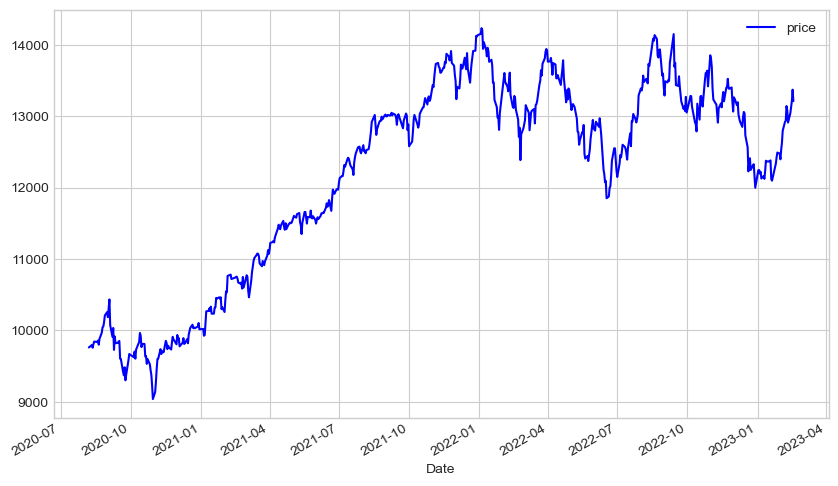

In [15]:
data.plot(figsize=(10,6), color='blue')
plt.savefig("raw_data.png", dpi=150, bbox_inches='tight')
plt.show()

* 2. Identity Model to be Tentatively Entertained

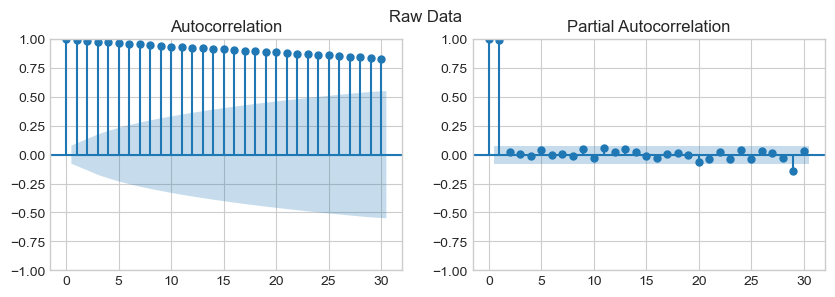

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(data.values.squeeze(),  lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=30, ax=ax[1])
plt.savefig("raw_data_ACF_PACF.png", dpi=150, bbox_inches='tight')
plt.show()

In [27]:
# acf나 pacf가 급격히 0으로 절단되는 모습을 보이지 않는다. 

In [18]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data['price'])

In [19]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.697275
p-value                          0.432517
#Lags Used                       0.000000
Number of Observations Used    624.000000
Critical Value (1%)             -3.440873
Critical Value (5%)             -2.866183
Critical Value (10%)            -2.569243
dtype: float64


In [31]:
# p value is 기준점(0.05)보다 크가 따라서 귀무가설을 기각하지 못한다. 귀무가설은 non-sationalry 이다.
# 따라서 해당 시계열 데이터는 non-stationary이다. 

In [32]:
# differencing

In [20]:
#diff_data = data.copy()
data['diff'] = data['price'].diff()
data = data.dropna()
print('########## Raw Data ##########')
print(data['diff'])

########## Raw Data ##########
Date
2020-08-10     24.0
2020-08-11     10.0
2020-08-12    -38.0
2020-08-13     48.0
2020-08-14     38.0
              ...  
2023-02-13    130.0
2023-02-14     90.0
2023-02-15     80.0
2023-02-16    160.0
2023-02-17   -160.0
Name: diff, Length: 624, dtype: float64


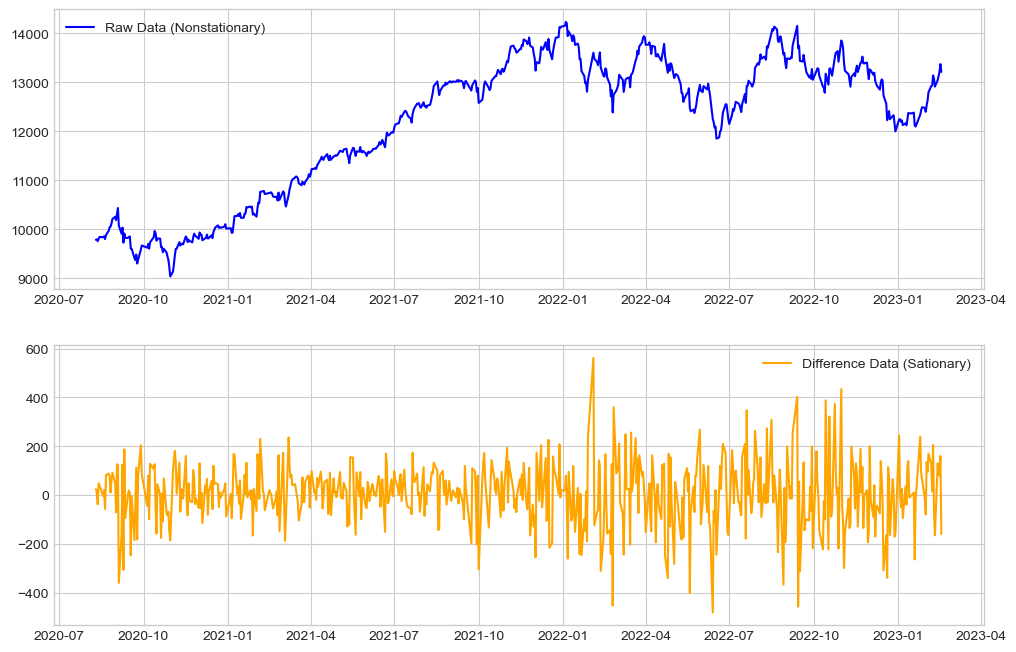

In [21]:
# Differenced data plot
plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(data['price'], color='blue')
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(data['diff'], 'orange')
plt.legend(['Difference Data (Sationary)'])
plt.savefig("raw_diff.png", dpi=150, bbox_inches='tight')
plt.show()

C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


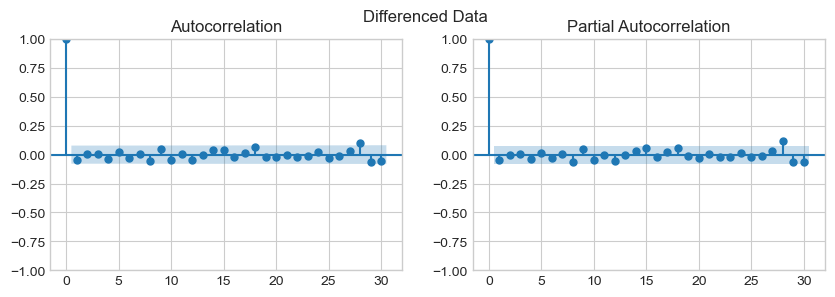

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(data['diff'].values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['diff'].values.squeeze(), lags=30, ax=ax[1])
plt.savefig("diff_data_ACF_PACF.png", dpi=150, bbox_inches='tight')
plt.show()

In [23]:
dftest2 = adfuller(data['diff'])

In [24]:
dfoutput2 = pd.Series(dftest2[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput2['Critical Value (%s)'%key] = value
print(dfoutput2)

Test Statistic                 -25.977668
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    623.000000
Critical Value (1%)             -3.440873
Critical Value (5%)             -2.866183
Critical Value (10%)            -2.569243
dtype: float64


* 3. Estimate Parameter

In [25]:
model = ARIMA(data['price'].values, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  624
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3901.682
Date:                Fri, 17 Feb 2023   AIC                           7811.364
Time:                        11:14:39   BIC                           7829.102
Sample:                             0   HQIC                          7818.257
                                - 624                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8672      0.115     -7.560      0.000      -1.092      -0.642
ma.L1          0.8338      0.120      6.930      0.000       0.598       1.070
ma.L2         -0.0623      0.036     -1.744      0.081      -0.132       0.008
sigma2      1.611e+04    683.960     23.559      0.000    1.48e+04    1.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                74.26
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
Ljung_box = sm.stats.acorr_ljungbox(model_fit.resid, lags=[1], return_df=True)

In [27]:
Ljung_box

,lb_stat,lb_pvalue
1,0.000123,0.991157


In [28]:
Ljung_box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lb_stat    1 non-null      float64
 1   lb_pvalue  1 non-null      float64
dtypes: float64(2)
memory usage: 24.0 bytes


In [29]:
LjungBox = model_fit.test_serial_correlation('ljungbox', lags=1)

In [30]:
LjungBox

array([[[0.01342754],
        [0.90774983]]])

In [31]:
LjungBox.shape

(1, 2, 1)

In [32]:
LjungBox[0,1,0]

0.907749831602729

In [33]:
LjungBox[-1]

array([[0.01342754],
       [0.90774983]])

In [34]:
# 귀무가설은 잔차항이 모두 독립적으로 분포되어 있다.
# 대립가설은 잔차항이 serial correlation되어 있다.
# 따라서 귀무가설을 가각하지 안하야야 한다. 즉 p값이 0.05보다 커야 한다.

In [35]:
round(model_fit.aic, 2)

7811.36

* 4. Diagnosis Check


In [36]:
# parameter seacrh

In [37]:
p = range(0,4)
d = range(1,4)
q = range(0,4)
pdq = list(itertools.product(p,d,q))

In [38]:
type(pdq)

list

In [39]:
len(pdq)

48

In [40]:
AIC = []
L_Box = []

for i in pdq:
    try:
        model = ARIMA(data['price'].values, order=(i))
        model_fit = model.fit()
        LjungBox = model_fit.test_serial_correlation('ljungbox', lags=1)
        LB = LjungBox[0,1,0]
        AIC.append(round(model_fit.aic,2))
        L_Box.append(round(LB,4))
        print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)},  Ljung-Box : {round(LB,4)}')
    except:
        continue

ARIMA: (0, 1, 0) >> AIC : 7809.03,  Ljung-Box : 0.2844
ARIMA: (0, 1, 1) >> AIC : 7810.02,  Ljung-Box : 0.9479
ARIMA: (0, 1, 2) >> AIC : 7812.04,  Ljung-Box : 0.9521
ARIMA: (0, 1, 3) >> AIC : 7813.97,  Ljung-Box : 0.948
ARIMA: (0, 2, 0) >> AIC : 8252.72,  Ljung-Box : 0.0
ARIMA: (0, 2, 1) >> AIC : 7806.31,  Ljung-Box : 0.2903
ARIMA: (0, 2, 2) >> AIC : 7807.34,  Ljung-Box : 0.9256
ARIMA: (0, 2, 3) >> AIC : 7809.35,  Ljung-Box : 0.9277
ARIMA: (0, 3, 0) >> AIC : 8929.77,  Ljung-Box : 0.0
ARIMA: (0, 3, 1) >> AIC : 8251.69,  Ljung-Box : 0.0


C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (0, 3, 2) >> AIC : 7818.35,  Ljung-Box : 0.4058
ARIMA: (0, 3, 3) >> AIC : 7818.5,  Ljung-Box : 0.9323
ARIMA: (1, 1, 0) >> AIC : 7810.0,  Ljung-Box : 0.9528
ARIMA: (1, 1, 1) >> AIC : 7812.01,  Ljung-Box : 0.9509
ARIMA: (1, 1, 2) >> AIC : 7811.36,  Ljung-Box : 0.9077
ARIMA: (1, 1, 3) >> AIC : 7812.57,  Ljung-Box : 0.9288
ARIMA: (1, 2, 0) >> AIC : 8059.34,  Ljung-Box : 0.0
ARIMA: (1, 2, 1) >> AIC : 7807.33,  Ljung-Box : 0.9289
ARIMA: (1, 2, 2) >> AIC : 7808.99,  Ljung-Box : 0.1417


C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA: (1, 2, 3) >> AIC : 7808.68,  Ljung-Box : 0.8893
ARIMA: (1, 3, 0) >> AIC : 8555.43,  Ljung-Box : 0.0
ARIMA: (1, 3, 1) >> AIC : 8061.47,  Ljung-Box : 0.0
ARIMA: (1, 3, 2) >> AIC : 7819.8,  Ljung-Box : 0.9357
ARIMA: (1, 3, 3) >> AIC : 7821.06,  Ljung-Box : 0.3804
ARIMA: (2, 1, 0) >> AIC : 7812.0,  Ljung-Box : 0.951
ARIMA: (2, 1, 1) >> AIC : 7814.0,  Ljung-Box : 0.9508
ARIMA: (2, 1, 2) >> AIC : 7809.77,  Ljung-Box : 0.5783


C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (2, 1, 3) >> AIC : 7809.87,  Ljung-Box : 0.9675
ARIMA: (2, 2, 0) >> AIC : 7981.93,  Ljung-Box : 0.0448
ARIMA: (2, 2, 1) >> AIC : 7809.33,  Ljung-Box : 0.9275
ARIMA: (2, 2, 2) >> AIC : 7808.48,  Ljung-Box : 0.9735
ARIMA: (2, 2, 3) >> AIC : 7805.58,  Ljung-Box : 0.4884
ARIMA: (2, 3, 0) >> AIC : 8360.6,  Ljung-Box : 0.0
ARIMA: (2, 3, 1) >> AIC : 7984.79,  Ljung-Box : 0.0506
ARIMA: (2, 3, 2) >> AIC : 7820.44,  Ljung-Box : 0.9424
ARIMA: (2, 3, 3) >> AIC : 7822.73,  Ljung-Box : 0.9513
ARIMA: (3, 1, 0) >> AIC : 7813.95,  Ljung-Box : 0.9587
ARIMA: (3, 1, 1) >> AIC : 7812.32,  Ljung-Box : 0.9757


C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (3, 1, 2) >> AIC : 7811.44,  Ljung-Box : 0.9619


C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (3, 1, 3) >> AIC : 7812.26,  Ljung-Box : 0.5751
ARIMA: (3, 2, 0) >> AIC : 7952.16,  Ljung-Box : 0.1779
ARIMA: (3, 2, 1) >> AIC : 7811.29,  Ljung-Box : 0.9344
ARIMA: (3, 2, 2) >> AIC : 7809.67,  Ljung-Box : 0.9505


C:\Users\OWNER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (3, 2, 3) >> AIC : 7808.36,  Ljung-Box : 0.8267
ARIMA: (3, 3, 0) >> AIC : 8269.68,  Ljung-Box : 0.0008
ARIMA: (3, 3, 1) >> AIC : 7955.43,  Ljung-Box : 0.1903
ARIMA: (3, 3, 2) >> AIC : 7988.79,  Ljung-Box : 0.0501
ARIMA: (3, 3, 3) >> AIC : 7824.74,  Ljung-Box : 0.9529


In [41]:
# Search optimal parameters

In [44]:
result01 = list(zip(pdq, AIC,L_Box)) # 같은 위치끼지 병합

In [45]:
len(result01)

48

In [46]:
type(result01)

list

In [47]:
result01

[((0, 1, 0), 7809.03, 0.2844),
 ((0, 1, 1), 7810.02, 0.9479),
 ((0, 1, 2), 7812.04, 0.9521),
 ((0, 1, 3), 7813.97, 0.948),
 ((0, 2, 0), 8252.72, 0.0),
 ((0, 2, 1), 7806.31, 0.2903),
 ((0, 2, 2), 7807.34, 0.9256),
 ((0, 2, 3), 7809.35, 0.9277),
 ((0, 3, 0), 8929.77, 0.0),
 ((0, 3, 1), 8251.69, 0.0),
 ((0, 3, 2), 7818.35, 0.4058),
 ((0, 3, 3), 7818.5, 0.9323),
 ((1, 1, 0), 7810.0, 0.9528),
 ((1, 1, 1), 7812.01, 0.9509),
 ((1, 1, 2), 7811.36, 0.9077),
 ((1, 1, 3), 7812.57, 0.9288),
 ((1, 2, 0), 8059.34, 0.0),
 ((1, 2, 1), 7807.33, 0.9289),
 ((1, 2, 2), 7808.99, 0.1417),
 ((1, 2, 3), 7808.68, 0.8893),
 ((1, 3, 0), 8555.43, 0.0),
 ((1, 3, 1), 8061.47, 0.0),
 ((1, 3, 2), 7819.8, 0.9357),
 ((1, 3, 3), 7821.06, 0.3804),
 ((2, 1, 0), 7812.0, 0.951),
 ((2, 1, 1), 7814.0, 0.9508),
 ((2, 1, 2), 7809.77, 0.5783),
 ((2, 1, 3), 7809.87, 0.9675),
 ((2, 2, 0), 7981.93, 0.0448),
 ((2, 2, 1), 7809.33, 0.9275),
 ((2, 2, 2), 7808.48, 0.9735),
 ((2, 2, 3), 7805.58, 0.4884),
 ((2, 3, 0), 8360.6, 0.0),
 ((2, 

In [48]:
np.shape(result01)

C:\Users\OWNER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(48, 3)

In [49]:
result02 = np.array(result01)

C:\Users\OWNER\AppData\Local\Temp\ipykernel_16400\2618018713.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result02 = np.array(result01)


In [50]:
result02[:, 2]

array([0.2844, 0.9479, 0.9521, 0.948, 0.0, 0.2903, 0.9256, 0.9277, 0.0,
       0.0, 0.4058, 0.9323, 0.9528, 0.9509, 0.9077, 0.9288, 0.0, 0.9289,
       0.1417, 0.8893, 0.0, 0.0, 0.9357, 0.3804, 0.951, 0.9508, 0.5783,
       0.9675, 0.0448, 0.9275, 0.9735, 0.4884, 0.0, 0.0506, 0.9424,
       0.9513, 0.9587, 0.9757, 0.9619, 0.5751, 0.1779, 0.9344, 0.9505,
       0.8267, 0.0008, 0.1903, 0.0501, 0.9529], dtype=object)

In [51]:
result02

array([[(0, 1, 0), 7809.03, 0.2844],
       [(0, 1, 1), 7810.02, 0.9479],
       [(0, 1, 2), 7812.04, 0.9521],
       [(0, 1, 3), 7813.97, 0.948],
       [(0, 2, 0), 8252.72, 0.0],
       [(0, 2, 1), 7806.31, 0.2903],
       [(0, 2, 2), 7807.34, 0.9256],
       [(0, 2, 3), 7809.35, 0.9277],
       [(0, 3, 0), 8929.77, 0.0],
       [(0, 3, 1), 8251.69, 0.0],
       [(0, 3, 2), 7818.35, 0.4058],
       [(0, 3, 3), 7818.5, 0.9323],
       [(1, 1, 0), 7810.0, 0.9528],
       [(1, 1, 1), 7812.01, 0.9509],
       [(1, 1, 2), 7811.36, 0.9077],
       [(1, 1, 3), 7812.57, 0.9288],
       [(1, 2, 0), 8059.34, 0.0],
       [(1, 2, 1), 7807.33, 0.9289],
       [(1, 2, 2), 7808.99, 0.1417],
       [(1, 2, 3), 7808.68, 0.8893],
       [(1, 3, 0), 8555.43, 0.0],
       [(1, 3, 1), 8061.47, 0.0],
       [(1, 3, 2), 7819.8, 0.9357],
       [(1, 3, 3), 7821.06, 0.3804],
       [(2, 1, 0), 7812.0, 0.951],
       [(2, 1, 1), 7814.0, 0.9508],
       [(2, 1, 2), 7809.77, 0.5783],
       [(2, 1, 3), 7809.87

In [52]:
result02[0]

array([(0, 1, 0), 7809.03, 0.2844], dtype=object)

In [53]:
result03 = [(result02[i]) for i, j in enumerate(result02[:,2]) if j > 0.05]

In [54]:
result03

[array([(0, 1, 0), 7809.03, 0.2844], dtype=object),
 array([(0, 1, 1), 7810.02, 0.9479], dtype=object),
 array([(0, 1, 2), 7812.04, 0.9521], dtype=object),
 array([(0, 1, 3), 7813.97, 0.948], dtype=object),
 array([(0, 2, 1), 7806.31, 0.2903], dtype=object),
 array([(0, 2, 2), 7807.34, 0.9256], dtype=object),
 array([(0, 2, 3), 7809.35, 0.9277], dtype=object),
 array([(0, 3, 2), 7818.35, 0.4058], dtype=object),
 array([(0, 3, 3), 7818.5, 0.9323], dtype=object),
 array([(1, 1, 0), 7810.0, 0.9528], dtype=object),
 array([(1, 1, 1), 7812.01, 0.9509], dtype=object),
 array([(1, 1, 2), 7811.36, 0.9077], dtype=object),
 array([(1, 1, 3), 7812.57, 0.9288], dtype=object),
 array([(1, 2, 1), 7807.33, 0.9289], dtype=object),
 array([(1, 2, 2), 7808.99, 0.1417], dtype=object),
 array([(1, 2, 3), 7808.68, 0.8893], dtype=object),
 array([(1, 3, 2), 7819.8, 0.9357], dtype=object),
 array([(1, 3, 3), 7821.06, 0.3804], dtype=object),
 array([(2, 1, 0), 7812.0, 0.951], dtype=object),
 array([(2, 1, 1),

In [55]:
result03 = np.array(result03)

In [56]:
min(result03[:,1])

7805.58

In [57]:
optimal = [(result03[i]) for i, j in enumerate(result03[:,1]) if j == min(result03[:,1])]

In [58]:
optimal

[array([(2, 2, 3), 7805.58, 0.4884], dtype=object)]

In [59]:
 optimal[0][0]

(2, 2, 3)

In [60]:
optimal01 =np.array(optimal)

In [61]:
optimal01[0,0]

(2, 2, 3)

In [62]:
orders = optimal01[0,0]

In [63]:
orders

(2, 2, 3)

In [64]:
model_opt = ARIMA(data['price'].values, order = orders)
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  624
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -3896.788
Date:                Fri, 17 Feb 2023   AIC                           7805.576
Time:                        11:15:39   BIC                           7832.174
Sample:                             0   HQIC                          7815.913
                                - 624                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9310      0.012   -164.845      0.000      -1.954      -1.908
ar.L2         -0.9917      0.012    -85.749      0.000      -1.014      -0.969
ma.L1          0.9313      0.045     20.576      0.000       0.843       1.020
ma.L2         -0.9430      0.083    -11.411      0.000      -1.105      -0.781
ma.L3         -0.9883      0.045    -21.844      0.000      -1.077      -0.900
sigma2      1.592e+04   1.53e-05   1.04e+09      0.000    1.59e+04    1.59e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                69.03
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+24. Standard errors may be unstable.
"""

In [65]:
len(model_opt_fit.fittedvalues)

624

In [66]:
fit=pd.Series(model_opt_fit.fittedvalues, copy=True)

In [67]:
fit

0          0.000000
1      14675.851570
2       9960.582540
3       9819.635290
4       9861.406775
           ...     
619    12917.684184
620    13037.716190
621    13147.963225
622    13199.427077
623    13395.203843
Length: 624, dtype: float64

In [68]:
data = data.reset_index()

In [69]:
data['fittedValue'] = fit

In [70]:
data.tail()

,Date,price,diff,fittedValue
619,2023-02-13,13040,130.0,12917.684184
620,2023-02-14,13130,90.0,13037.716190
621,2023-02-15,13210,80.0,13147.963225
622,2023-02-16,13370,160.0,13199.427077
623,2023-02-17,13210,-160.0,13395.203843


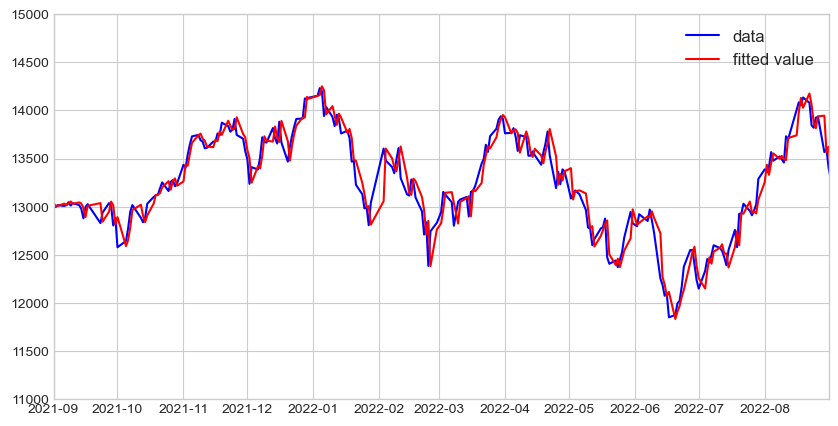

In [71]:
import datetime

plt.figure(figsize=(10,5))
plt.plot(data['Date'], data['price'], color='blue')
plt.plot(data['Date'], data['fittedValue'], color='red')
plt.legend(['data', 'fitted value'], loc='upper right', fontsize=12)
plt.xlim(datetime.date(2021,9,1), datetime.date(2022, 8,31))
plt.ylim(11000, 15000)
plt.grid(True)
plt.savefig("raw_fitted.png", dpi=150, bbox_inches='tight')
plt.show()